In [24]:
import os
import torch
import numpy as np
import pandas as pd
from torch import nn
from datetime import datetime
import matplotlib.pyplot as plt
from torchvision import datasets
from collections import OrderedDict
from sklearn.model_selection import KFold
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,Dataset
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## DATA
- input X: data "images" that contains stocks' information such as open, high, low, close, vwap, volume, return1, turn, free_turn, in a given time interval
- label Y: the normalized return of the input stock in the given time interval

In [25]:
def normalize(y):
    y_norm = np.empty((y.shape))
    for i in range(len(y)):
        return_ = y[i]
        mean_   = np.nanmean(return_)
        std_    = np.nanstd(return_)
        y_norm[i] = (return_-mean_) / std_
    return y_norm

In [26]:
def load_dataset():
    '''
    load 数据并使时间成为第一个维度
    '''
    X_5  = np.load('x5.npy')
    X_10 = np.load('x10.npy')
    Y_5  = np.load('y5.npy')
    Y_10 = np.load('y10.npy')
    ts_code_list = np.load('ts_code_list.npy')
    sample_date = X_5[:,0,:,0,-1] # 采样日期
    sample_date = [datetime.strptime(str(int(item)),"%Y%m%d") for item in sample_date]
    X_5  = X_5[:,:,:,1:,:]
    X_10 = X_10[:,:,:,1:,:]
    return X_5, X_10, Y_5, Y_10, sample_date, ts_code_list

## Parameters

In [27]:
feature_layer_stride = 10
pooling_layer_stride = 3
batch_size           = 1000

## Feature Extract Layer Functions

In [28]:
def generateC(n):
    '''
    生成组合数数对
    '''
    pair = []
    for i in range(n):
        for j in range(n):
            if all([i!=j,i<j]):
                pair.append([i,j])
    return pair

def ts_corr(X,pairs,d=10,stride=10):
    """
    过去d天X值构成的时序数列和Y值构成的时序数列的相关系数
    corr = cov(X,Y) / ( std(X) * std(Y) )
    """
    shape1,shape2,shape3,shape4,shape5 = X.shape
    all_corr = np.empty((shape1,shape2,shape3,len(pairs),3))
    X_ = np.reshape(X,(shape1,shape2,shape3,shape4,-1,stride))
    mean = np.mean(X_,axis=-1,keepdims=True)
    std  = np.std(X_,axis=-1,keepdims=True)
    x_center = X_ - mean
    for i, pair in enumerate(pairs):
        x_idx,y_idx = pair[0],pair[1]
        x = x_center[:,:,:,x_idx:x_idx+1,...]
        y = x_center[:,:,:,y_idx:y_idx+1,...]
        x_std = std[:,:,:,x_idx:x_idx+1,...]
        y_std = std[:,:,:,y_idx:y_idx+1,...]
        cov = np.sum(x*y,axis=-1,keepdims=True) / d
        corr = (cov / (x_std*y_std))[:,:,:,:,:,0]
        all_corr[:,:,:,i:i+1,:] = corr
    return all_corr

def ts_cov(X,pairs,d=10,stride=10):
    """
    过去d天X值构成的时序数列和Y值构成的时序数列的协方差
    Sum( (X-mean(X)) * (Y-mean(Y)) ) / # of time segment
    """
    shape1,shape2,shape3,shape4,shape5 = X.shape
    all_cov = np.empty((shape1,shape2,shape3,len(pairs),3))
    X_ = np.reshape(X,(shape1,shape2,shape3,shape4,-1,stride))
    mean = np.mean(X_,axis=-1,keepdims=True)
    x_center = X_ - mean
    for i, pair in enumerate(pairs):
        x_idx,y_idx = pair[0],pair[1]
        x = x_center[:,:,:,x_idx:x_idx+1,...]
        y = x_center[:,:,:,y_idx:y_idx+1,...]
        cov = np.sum(x*y,axis=-1) / d
        all_cov[:,:,:,i:i+1,:] = cov
    return all_cov

def ts_stddev(X,d=10,stride=10):
    """
    过去 d 天 X 值构成的时序数列的标准差
    """
    shape1,shape2,shape3,shape4,shape5 = X.shape
    X_ = np.reshape(X,(shape1,shape2,shape3,shape4,-1,stride))
    std  = np.std(X_,axis=-1)
    return std

def ts_zscore(X,d=10,stride=10):
    """
    过去 d 天 X 值构成的时序数列的平均值除以标准差。
    """
    shape1,shape2,shape3,shape4,shape5 = X.shape
    X_ = np.reshape(X,(shape1,shape2,shape3,shape4,-1,stride))
    mean = np.mean(X_,axis=-1)
    std  = np.std(X_,axis=-1)
    zscore = mean / (std+1e-5)
    return zscore

def ts_return(X,d=10,stride=10):
    """
    (X - delay(X, d))/delay(X, d)-1, delay(X, d)为 X 在 d 天前的取值。
    """
    shape1,shape2,shape3,shape4,shape5 = X.shape
    X_ = np.reshape(X,(shape1,shape2,shape3,shape4,-1,stride))
    x = X_[:,:,:,:,:,-1:]
    delay = X_[:,:,:,:,:,0:1]
    return_ = (x-delay) / (delay-1)
    return return_.reshape(shape1,shape2,shape3,shape4,-1)

def ts_decaylinear(X,d=10,stride=10):
    """
    过去 d 天 X 值构成的时序数列的加权平均值，权数为 d, d – 1, …, 1(权数之和应为 1，需进行归一化处理)，
    其中离现在越近的日子权数越大
    """
    shape1,shape2,shape3,shape4,shape5 = X.shape
    X_ = np.reshape(X,(shape1,shape2,shape3,shape4,-1,stride))
    weight = np.arange(1,d+1)
    weight = (weight / np.sum(weight)).reshape(1,-1)
    decaylinear = np.sum(X_*weight,axis=-1) / np.sum(weight)
    return decaylinear

def ts_mean(X,d=10,stride=10):
    """
    过去 d 天 X 值构成的时序数列之和
    """
    shape1,shape2,shape3,shape4,shape5 = X.shape
    X_ = np.reshape(X,(shape1,shape2,shape3,shape4,-1,stride))
    mean = np.mean(X_,axis=-1)
    return mean

In [29]:
def feature_extract(input_):
    '''
    param: data image
    return: feature layer
    '''
    pairs = generateC(9)
    ts_corr10        = ts_corr(input_,pairs)
    ts_cov10         = ts_cov(input_,pairs)
    ts_stddev10      = ts_stddev(input_)
    ts_zscore10      = ts_zscore(input_)
    ts_return10      = ts_return(input_)
    ts_decaylinear10 = ts_decaylinear(input_)
    ts_mean10        = ts_mean(input_)
    feature_layer = np.concatenate((ts_corr10,ts_cov10,ts_stddev10,ts_zscore10,ts_return10,ts_decaylinear10,ts_mean10),axis=3)
    return feature_layer


In [30]:
def replace_nan_w_zero(x,y):
    nan_idx = (x != x).nonzero()
    date  = nan_idx[0]
    stock = nan_idx[1]
    date_stock_pair = [p for p in zip(date,stock) if None not in p]
    date_stock_pair = list(set(date_stock_pair))
    date_stock_pair = sorted(date_stock_pair,key=lambda tup:(tup[0],tup[1]))
    for idx in date_stock_pair:
        x[idx] = 0
        y[idx] = 0
    return x,y

In [31]:
def preprocess_input(x,y):
    '''
    feature extract后, BN前的输入
    '''
    x = feature_extract(x)
    x,y = replace_nan_w_zero(x,y)
    shape1,shape2,shape3,shape4,shape5 = x.shape
    x = np.reshape(x,(-1,shape3,shape4,shape5))
    y = np.reshape(y,(-1,shape3))
    return x, y

## Get dataloader

In [32]:
def shuffle_dataset(x,y):
    idx = np.arange(len(x))
    np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    return x,y

In [33]:
class alphanet_dataset(Dataset):
    def __init__(self,data,label):
        self.data = torch.from_numpy(data)
        self.label = torch.from_numpy(label)
    def __getitem__(self,index):
        return self.data[index],self.label[index]
    def __len__(self):
        return len(self.data)

In [34]:
def normalize_input(x):
    mean = np.nanmean(x,axis=(3,4))[...,np.newaxis,np.newaxis]
    std  = np.nanstd(x,axis=(3,4))[...,np.newaxis,np.newaxis]
    norm = (x - mean) / (std + 1e-5)
    return norm

In [35]:
X_5, X_10, Y_5, Y_10, sample_date, ts_code_list = load_dataset()
# normalize label
# print(X_5[-3,500])
X_5 = normalize_input(X_5)
X_10 = normalize_input(X_10)
Y_norm5  = normalize(Y_5)
Y_norm10 = normalize(Y_10)
dev_idx   = int(len(sample_date)*0.5)

x_train5 = X_5[:dev_idx]
y_train5 = Y_norm5[:dev_idx]
x_train10 = X_10[:dev_idx]
y_train10 = Y_norm10[:dev_idx]

x_dev5 = X_5[dev_idx:]
y_dev5 = Y_norm5[dev_idx:]
x_dev10 = X_10[dev_idx:]
y_dev10 = Y_norm10[dev_idx:]

c:\vnstudio\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\vnstudio\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [36]:
X_5.shape

(543, 583, 1, 9, 30)

In [49]:
def get_dataloader(x,y,shuffle):
    # if shuffle:
    #     x,y = shuffle_dataset(x,y)
    x_,y_ = preprocess_input(x,y)
    dataset = alphanet_dataset(x_,y_)
    dataloader = DataLoader(dataset,batch_size=583*2,shuffle=False)
    return dataloader

In [50]:
# train dataloader
tr_loader5   = get_dataloader(x_train5,y_train5,True)
tr_loader10  = get_dataloader(x_train10,y_train10,True)

dev_loader5  = get_dataloader(x_dev5,y_dev5,False)
dev_loader10 = get_dataloader(x_dev10,y_dev10,False)

# te_loader5,te_nan5   = get_dataloader(x_test5,y_test5,False)
# te_loader10,te_nan10 = get_dataloader(x_test10,y_test10,False)


In [51]:
wholeloader5 = get_dataloader(X_5,Y_norm5,False)
wholeloader10 = get_dataloader(X_10,Y_norm10,False)

In [52]:
# 2020年开始
wholeloader2020 = get_dataloader(X_5[473:],Y_norm5[473:],False)

In [53]:
class AlphaNet(nn.Module):
    def __init__(self):
        super(AlphaNet,self).__init__()
        self.bn1 = nn.BatchNorm2d(117)
        self.bn2 = nn.BatchNorm2d(351)

        self.maxpool = nn.MaxPool2d(kernel_size=(1,3))
        self.avgpool = nn.AvgPool2d(kernel_size=(1,3))
        self.minpool = nn.MaxPool2d(kernel_size=(1,3))

        self.flatten1 = nn.Flatten(start_dim=1)
        self.flatten2 = nn.Flatten(start_dim=1)
        self.fc      = nn.Linear(702,30)
        self.dropout = nn.Dropout(0.5)
        self.relu    = nn.ReLU()
        self.output  = nn.Linear(30,1)
        self._init_weight()

    def _init_weight(self):
        nn.init.trunc_normal_(self.fc.weight)
        nn.init.trunc_normal_(self.output.weight)
        nn.init.trunc_normal_(self.fc.bias)
        nn.init.trunc_normal_(self.output.bias)

    def forward(self,input_):
        feature = self.bn1(input_)
        maxpool = self.maxpool(feature)
        avgpool = self.avgpool(feature)
        minpool = -self.maxpool(-1*feature)
        pool_feature = torch.cat((maxpool,avgpool,minpool),axis=1)
        pool_feature = self.bn2(pool_feature)

        feature_flatten      = self.flatten1(feature)
        pool_feature_flatten = self.flatten2(pool_feature)
        output_ = torch.hstack([feature_flatten,pool_feature_flatten])

        output_       = self.fc(output_)
        output_       = self.relu(output_)
        output_       = self.dropout(output_)
        output_       = self.output(output_)
        return output_

## Model Train & Test

In [54]:
learning_rate        = 0.0001
early_stopping       = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model = AlphaNet().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(),lr=learning_rate)

## Training

In [55]:
def train(trainloader, devloader, model, loss_fn, optimizer, path):

    min_valid_loss = np.inf
    cnt = 0
    save_model = False
    epochs = 400

    train_loss_list = []
    eval_loss_list = []
    for epoch in range(epochs):
        optimizer = torch.optim.RMSprop(model.parameters(),lr=0.00001)

        print('\nEpoch {} / {}'.format(epoch+1,epochs))
        model.train()
        train_loss = 0.0
        for data,label in trainloader:
            data = np.transpose(data,(0,2,1,3))
            data,label = data.to(device),label.to(device) 
            pred = model(data.float())

            loss = loss_fn(pred,label.float())
            train_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss_list.append(train_loss.item()/len(trainloader))
        model.eval()
        eval_loss = 0.0
        for data,label in devloader:
            data = np.transpose(data,(0,2,1,3))
            data,label = data.to(device),label.to(device) 
            pred = model(data.float())
            loss = loss_fn(pred,label.float())
            eval_loss += loss
        eval_loss_list.append(eval_loss.item()/len(devloader))
        print('train loss: ', train_loss.item()/len(trainloader),'| dev loss: ', eval_loss.item()/len(devloader))
        if eval_loss < min_valid_loss:
            min_valid_loss = eval_loss
            cnt = 0
            print('save model')
            torch.save(model.state_dict(), path)
            save_model = True
        # loss没有update, increment cnt
        cnt += 1
        if cnt >= early_stopping and save_model == True:
            print('early stop')
            break
        elif cnt >= early_stopping and save_model == False:
            print('early stop and save model')
            torch.save(model.state_dict(),path)
            save_model = True
            break
        
    plt.figure(figsize=(20,12))
    plt.plot(train_loss_list,label='train loss')
    plt.plot(eval_loss_list,label='dev loss')
    plt.legend()

In [56]:
# train(x_tr5,y_tr5,model,loss_fn,optimizer)
path = './model_param.pth'
path5 = './model_param5.pth'
path10 = './model_param10.pth'

good_model_path = './model_param_v2.pth'

In [57]:
train(tr_loader5,dev_loader5,model,loss_fn,optimizer,path5)


Epoch 1 / 400


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.99 GiB already allocated; 0 bytes free; 3.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
from torchsummary import summary
# summary(model,( 117,1, 3))
# model.fc.weight.grad#, model.output.weight.grad

## Testing

In [ ]:
def layering(alpha,origin, sample_date):
    layer_size = 5
    layer=[[] for i in range(layer_size)]
    alpha = np.nan_to_num(alpha)
    for i in range(len(alpha)):
        alpha_daily = pd.DataFrame(alpha[i,...],columns=['return']) # 每天每股因子值
        alpha_daily = alpha_daily.sort_values(by='return',ascending=False,na_position='last') # 按照因子值排序
        rank_idx = list(alpha_daily.index)
        return_daily = pd.DataFrame(origin[i,...],columns=['return'])
        return_daily = return_daily.reindex(rank_idx)
        return_daily_cent = return_daily - return_daily.mean()
        split = np.array_split(return_daily_cent,layer_size) # 分层
        for j in range(layer_size):
            mean_ = split[j]['return'].mean()
            layer[j].append(mean_)

    for i in range(layer_size):
        layer[i] = np.nancumsum(layer[i])
    plt.figure(figsize=(20,10))
    plt.plot(sample_date,layer[0],label = "top")
    # plt.plot(sample_date,layer[1],label = "m1")
    # plt.plot(sample_date,layer[2],label = "m2")
    # plt.plot(sample_date,layer[3],label = "m3")
    plt.plot(sample_date,layer[4],label = "bot")
    plt.legend()
    return

def RankIC_mean_std(original,pred,sample_date):
    rankic = []
    for i in range(len(original)): # 每个截面
        ori_cross = original[i]
        pred_cross = pred[i]
        rankic.append(pd.DataFrame([ori_cross.reshape(-1),pred_cross.reshape(-1)]).T.corr(method='spearman').iloc[0,1])
    rankic_mean = np.nanmean(rankic)
    rankic_std = np.nanstd(rankic)
    rankic_cumsum = np.nancumsum(rankic)
    plt.figure(figsize=(20,10))
    plt.plot(sample_date,rankic_cumsum,label='rankic')
    plt.legend()
    return rankic_mean,rankic_std,rankic_cumsum

In [ ]:
def test(testloader,origin,sample_date,model, loss_fn):
    model.eval()
    test_loss_list = []
    alpha = []
    with torch.no_grad():
        test_loss = 0.0
        for data,label in testloader:
            data = np.transpose(data,(0,2,1,3))
            data,label = data.to(device),label.to(device) 
            pred = model(data.float())
            loss = loss_fn(pred,label.float())
            test_loss += loss
            alpha.append(pred.cpu().numpy())
            return_layer = {
                'bn1':'bn1',
                'bn2':'bn2',
                'flatten1':'flatten1',
                'flatten2':'flatten2',
                'fc':'fc',
                # 'relu':'relu',
                # 'output':'output'
            }
            mid_getter = MidGetter(model,return_layers=return_layer,keep_output=True)
            mid_outputs, model_output = mid_getter(data.float())
            # print(mid_outputs['bn1'][:,0,:,:].nanmean())
            # print(mid_outputs['flatten2'].shape)
            # print(mid_outputs['fc'].shape)
            # print(model_output)
        test_loss_list.append(test_loss.item()/len(testloader))
        print('test loss: ', test_loss.item()/len(testloader))
    arr = np.vstack(alpha)
    # pred = reconstruct_alpha(arr,origin,nan_pair)
    pred = np.reshape(arr,(-1,583,1))
    rankic_mean,rankic_std,rankic_cumsum = RankIC_mean_std(origin,pred,sample_date)
    print('RankIC mean: {} | RankIC std {}'.format(rankic_mean,rankic_std))
    layering(pred,origin, sample_date)

## test for 5天调仓周期

test loss:  1.4322370228014494
RankIC mean: 0.09871033400547406 | RankIC std 0.11650199936952975


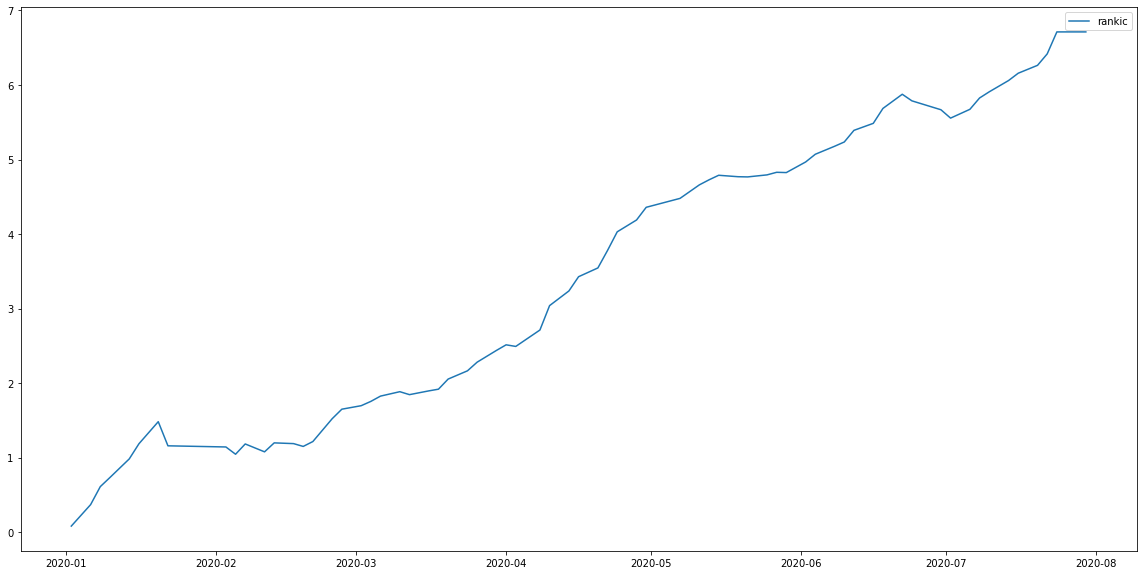

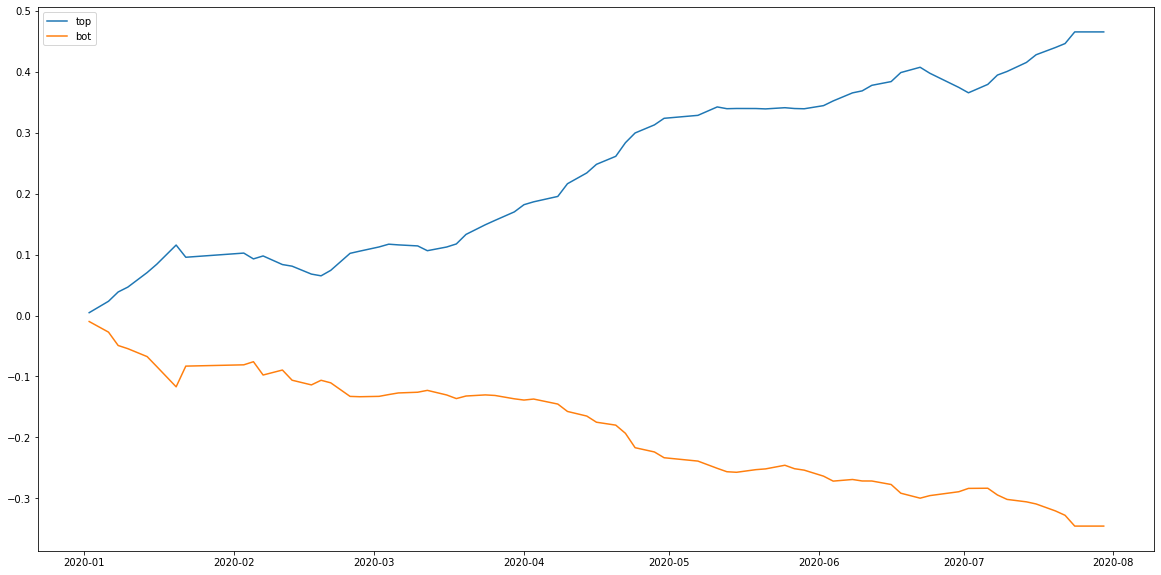

In [ ]:
# model.load_state_dict(torch.load('./model_rankic_correct.pth'))
model.load_state_dict(torch.load(path5))

# test(te_loader5,Y_5[test_idx:],te_nan5,sample_date[test_idx:],model,loss_fn)
test(wholeloader2020,Y_5[473:],sample_date[473:],model,loss_fn)
# test(wholeloader5,Y_5,sample_date,model,loss_fn)

In [ ]:
model.load_state_dict(torch.load(path5))
test(wholeloader5,Y_5,sample_date,model,loss_fn)

In [ ]:
model.load_state_dict(torch.load('./model_rankic_correct.pth'))
param_dict = {}
for name,param in model.named_parameters():
    if param.requires_grad:
        param_dict[name] = param.data

In [ ]:
def batchnorm(x,param_dict,model):
    x = x.cpu().numpy()
    channel_mean = np.nanmean(x,axis=(0,2,3)).reshape(-1,1)
    channel_std  = np.nanstd(x,axis=(0,2,3)).reshape(-1,1)
    # channel_var = np.power(np.nanstd(x,axis=(0,2,3)),2)
    bn1_weight = param_dict['bn1.weight'].cpu().numpy().reshape(-1,1) # 117
    bn1_bias = param_dict['bn1.bias'].cpu().numpy().reshape(-1,1)     # 117
    bn = ((np.squeeze(x)-channel_mean) /(channel_std+1e-5)) * bn1_weight + bn1_bias
    # bn = ((np.squeeze(x)-model.bn1.running_mean.cpu().numpy().reshape(-1,1)) /(np.power(model.bn1.running_var.cpu().numpy().reshape(-1,1),0.5)+1e-5)) * bn1_weight + bn1_bias
    return bn

c:\vnstudio\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


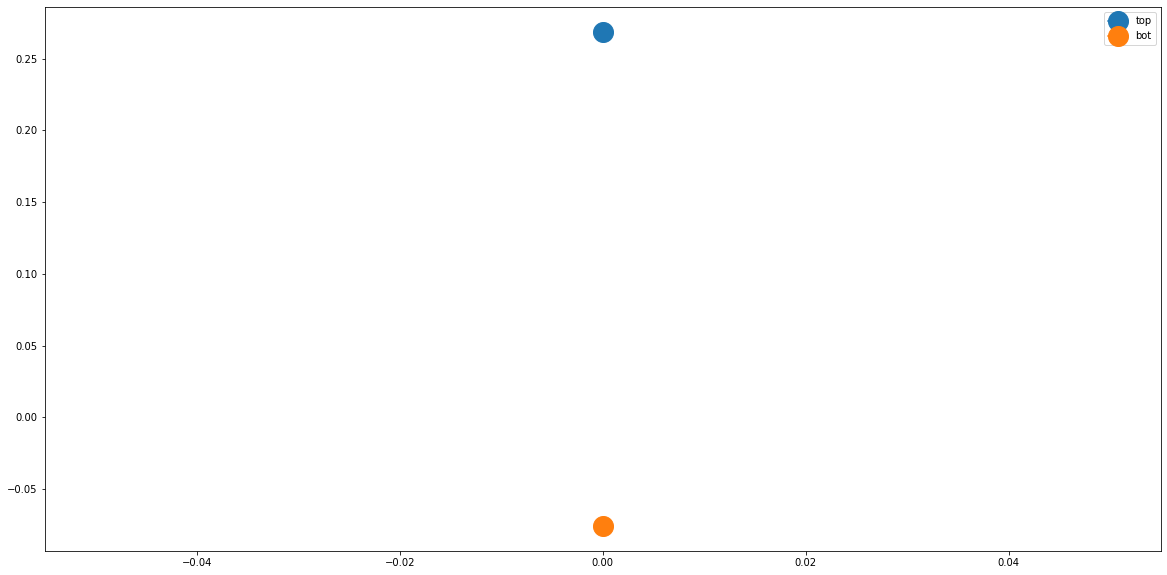

In [ ]:
def test_(x,model,loss_fn):
    model.eval()
    alpha_list = []
    with torch.no_grad():
        x = np.transpose(x,(0,2,1,3))
        x = torch.from_numpy(x)
        x = x.to(device)
        pred = model(x.float())
        alpha_list.append(pred.cpu().numpy())
    alpha = np.vstack(alpha_list)
    # print(alpha)
    test_layering(alpha)
    return 
# model.load_state_dict(torch.load(good_model_path))
model.eval()
x829  = np.load('x829.npy')
# x92 = X_5[-3]
# x92 = x92[np.newaxis,...]
# print(x92.shape)

# y92  = np.load('y92.npy')
x829 = x829[np.newaxis,:,np.newaxis,1:,:]
# print(x92[0,500])

x829 = normalize_input(x829)
# x724 = normalize_input(X_5[-3][np.newaxis,...])
# diff_idx = (X_5[-3][np.newaxis,...] != x724).nonzero()
# diff = list(np.setdiff1d(x724.reshape(-1),X_5[-3].reshape(-1)))
# # print(len(diff))
# diff_pair = [p for p in zip(diff_idx[0],diff_idx[1],diff_idx[2],diff_idx[3]) if None not in p]
# diff_pair = list(set(diff_pair))
# print(diff_pair)

# y92 = y92[np.newaxis,...]
x_feature = feature_extract(x829)
x_feature = np.reshape(x_feature,(-1,1,117,3))
test_(x_feature,model,loss_fn)
x = torch.from_numpy(x_feature)
x = np.transpose(x,(0,2,1,3))
x = x.to(device)
return_layer = { ## layer to read
    'bn1':'bn1',
    'bn2':'bn2',
    'maxpool':'maxpool',
    'avgpool':'avgpool',
    'minpool':'minpool',
    'flatten1':'flatten1',
    'flatten2':'flatten2',
    'fc':'fc',
    'relu':'relu',
    'output':'output'
}
# # 得到中间layer的结果
mid_getter = MidGetter(model,return_layers=return_layer,keep_output=True)
mid_outputs, model_output = mid_getter(x.float())
# flatten_layer = torch.cat((mid_outputs['flatten1'],mid_outputs['flatten2']),axis=1)
# fc_layer = torch.inner(flatten_layer,param_dict['fc.weight'])# + param_dict['fc.bias']

In [ ]:
x5tmp = X_5[-3][np.newaxis,...]
# for i in range(len(diff_pair)):
    
#     print(i,x5tmp[diff_pair[i]],x724[diff_pair[i]])
# X_5[-3].shape,x724[0].shape
# diff_pair[107]

datetime.datetime(2020, 7, 24, 0, 0)

In [ ]:
x5tmp[0,145]
pd.DataFrame(X_5[-4,145,0].T)

,0,1,2,3,4,5,6,7,8
0,4.11,4.14,4.04,4.06,4.077769,17872080.0,0.000000,0.010914,0.011669
1,4.10,4.15,4.05,4.06,4.081959,9543113.0,0.000000,0.005828,0.006231
2,4.10,4.13,4.04,4.06,4.079227,14494916.0,0.000000,0.008852,0.009464
3,4.02,4.10,3.98,4.06,4.063407,13239127.0,-0.009852,0.008085,0.008644
4,4.08,4.10,4.02,4.02,4.044300,9006903.0,0.012438,0.005500,0.005881
5,4.05,4.09,4.05,4.07,4.066762,9414171.0,-0.004914,0.005749,0.006147
6,4.05,4.07,3.98,4.05,4.030943,11796314.0,0.002469,0.007204,0.007702
7,4.06,4.08,4.02,4.06,4.050609,8644420.0,0.007389,0.005279,0.005644
8,4.04,4.09,4.04,4.09,4.066936,12609606.0,-0.022005,0.007700,0.008233
9,4.09,4.13,3.99,4.00,4.052745,16522118.0,0.000000,0.010090,0.010788


## train and test for 10天调仓周期

In [ ]:
train(tr_loader10,dev_loader10,model,loss_fn,optimizer,path10)


28088
28088
RankIC mean: 0.1053174917082928 | RankIC std 0.11199283106099467


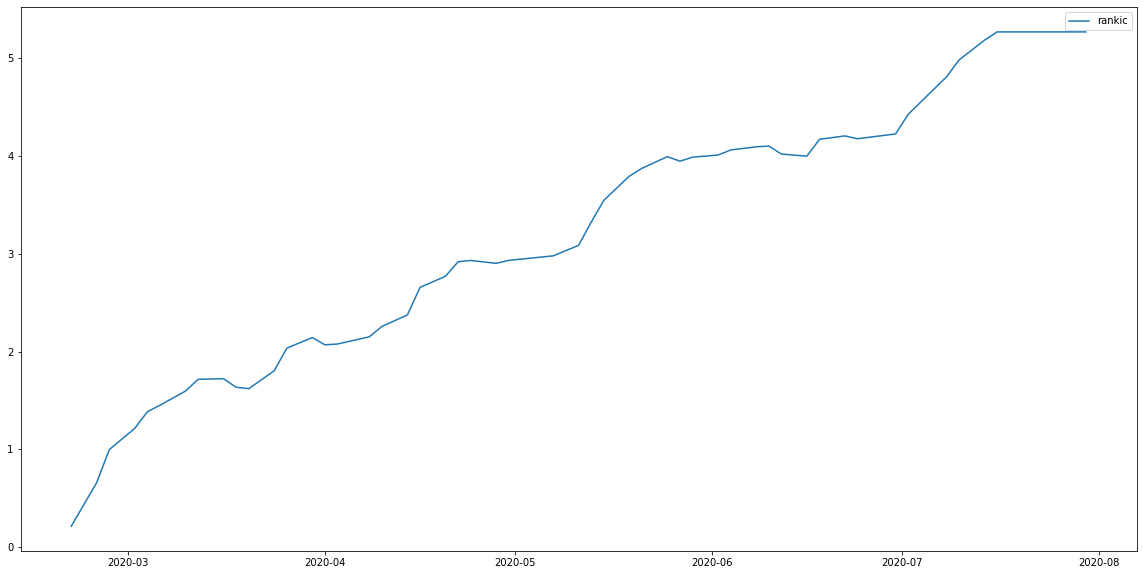

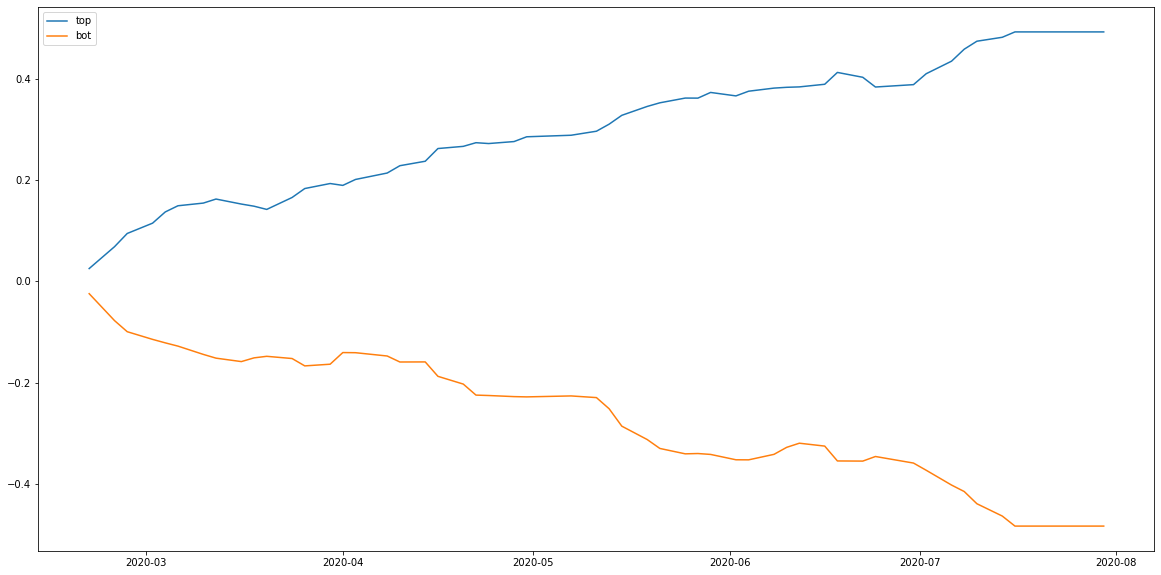

In [ ]:
# model.load_state_dict(torch.load(path10))

test(te_loader10,Y_10[test_idx:],te_nan10,sample_date[test_idx:],model,loss_fn)


In [ ]:
print(len(te_nan10))

3977


In [ ]:
pd.DataFrame([original.reshape(-1),new.detach().numpy().reshape(-1)]).T.corr(method='spearman').iloc[0,1]